## PyAugment Package Demonstration

This notebook shows an easy demonstration of how pyaugment can be easily utilized. 

In [4]:
# Importing necessary libraries
from pyaugment import pyaugment as aug
from pyaugment import utilfuncs as util

In [5]:
import pandas as pd
import numpy as np
# Turn off warnings to save page space
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Simple Example

The dataset utilized is from https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

In [6]:
data = pd.read_csv('data/Stores.csv')
data = data.rename(columns = {'Store ID ':'Store_ID'})

In [7]:
data

Store_ID  Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0           1        1659             1961                   530        66490
1           2        1461             1752                   210        39820
2           3        1340             1609                   720        54010
3           4        1451             1748                   620        53730
4           5        1770             2111                   450        46620
..        ...         ...              ...                   ...          ...
891       892        1582             1910                  1080        66390
892       893        1387             1663                   850        82080
893       894        1200             1436                  1060        76440
894       895        1299             1560                   770        96610
895       896        1174             1429                  1110        54340

[896 rows x 5 columns]

For this simple example, we can see that each of the variables, other than Store_ID, are continuous integers, which makes it easy for augmentation.

### Data Wrangling

Before augmenting the data, first split into train/validation/test, or train/test based on use-case. We will only augment the training data as augmenting the whole dataset and then splitting causes data leakage, which introduces bias.

In [8]:
train, test = util.traintestval_split(df = data, with_val = False)

### Augmentation with CTGAN

First, we need to obtain the table meta_data and save it as a dictionary. This can be done with the function aug.get_metadata(). NOTE: If a unique, primary key is not given in the table, use utils.id_row() to obtain the index and use those as unique identifiers. Otherwise, it becomes difficult to separate real data vs augmented data due to repetitions of rows with the same id.

In [13]:
# Create Metada of table
stores_metadata = aug.get_metadata(df= data, table_name = 'Stores', primary_key = 'Store_ID')
stores_metadata

{'Store_ID': {'type': 'id', 'subtype': 'integer'},
 'Store_Area': {'type': 'numerical', 'subtype': 'integer'},
 'Items_Available': {'type': 'numerical', 'subtype': 'integer'},
 'Daily_Customer_Count': {'type': 'numerical', 'subtype': 'integer'},
 'Store_Sales': {'type': 'numerical', 'subtype': 'integer'}}

Check to see if the table metadata is correct. If not, you can manually adjust each of the fields as needed. Now we wil create a CTGAN Model and augment the train set.

In [20]:
# Training the CTGAN Model
ctgan_model = aug.Augment_model(method = 'CTGAN', 
                                df = train,
                                primary_key = 'Store_ID',
                                field_types = stores_metadata, #Field_types not needed if metadata matches desired input.
                                batch_size = 100,
                                epochs = 1000)

c:\Users\jeffreylee4\Anaconda3\envs\DataAugDemo\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
c:\Users\jeffreylee4\Anaconda3\envs\DataAugDemo\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
c:\Users\jeffreylee4\Anaconda3\envs\DataAugDemo\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
c:\Users\jeffreylee4\Anaconda3\envs\DataAugDemo\lib\site-packages\sklearn\mixture\_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate dat

In [15]:
# Generate 50% of the training set
# After rigorous testing, generating ~ 50% or less samples provided the best results
augmented_data = aug.sample(ctgan_model,
                            num_rows = round(train.shape[0]*.5/10)*10,
                            batch_size = 100,
                            randomize_samples = True)
augmented_data                            

Store_ID  Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0           0        1948             2448                   870        75040
1           1        1392             1870                  1140        53950
2           2        1618             1684                   800        41890
3           3        1496             1833                   500        64300
4           4        1518             1873                   810        47670
..        ...         ...              ...                   ...          ...
335       335        1457             1530                   990        48440
336       336        1716             2287                   810        52960
337       337        1074             1006                   770        55850
338       338        2028             1917                  1220        58570
339       339        1103             1269                  1130        85330

[340 rows x 5 columns]

Check the model simularity with Chi-Square and KS Tests.

In [16]:
aug.evaluate_statmetrics(augmented_df = augmented_data,
                        df = train,
                        method = 'CS_KS')

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared        NaN   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.779118   

   normalized_score  min_value  max_value      goal  \
0               NaN        0.0        1.0  MAXIMIZE   
1          0.779118        0.0        1.0  MAXIMIZE   

                                               error  
0  Cannot find fields of types ('boolean', 'categ...  
1                                               None

Let's take a visual look as well

array([[<AxesSubplot:title={'center':'Store_Area'}>,
        <AxesSubplot:title={'center':'Items_Available'}>],
       [<AxesSubplot:title={'center':'Daily_Customer_Count'}>,
        <AxesSubplot:title={'center':'Store_Sales'}>]], dtype=object)

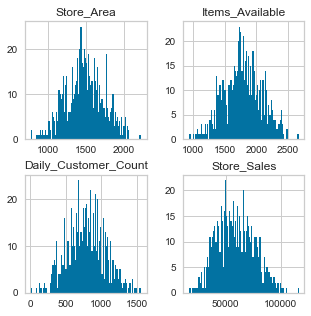

In [17]:
trainhist = train.drop('Store_ID', axis = 1)
aughist = augmented_data.drop('Store_ID', axis = 1)

trainhist.hist(bins = 100, figsize = (5,5))

array([[<AxesSubplot:title={'center':'Store_Area'}>,
        <AxesSubplot:title={'center':'Items_Available'}>],
       [<AxesSubplot:title={'center':'Daily_Customer_Count'}>,
        <AxesSubplot:title={'center':'Store_Sales'}>]], dtype=object)

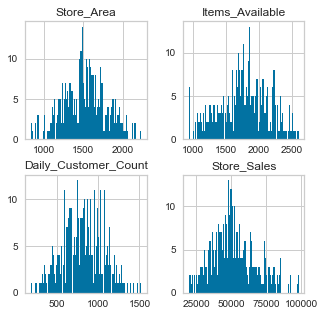

In [18]:
aughist.hist(bins = 100, figsize = (5,5))

Finally, we augment the train set with augmented data to create our finalized augmented train set  

In [19]:
augmented_train = aug.Augmented_DF(train_df = train, aug_only = augmented_data)
augmented_train

Store_ID  Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0         744        1418             1699                   870        49160
1         500        1335             1601                   460        50820
2         345        2004             2390                   930        50130
3         664        1717             2048                   700        78530
4         645        1767             2121                  1050        78430
..        ...         ...              ...                   ...          ...
335       335        1457             1530                   990        48440
336       336        1716             2287                   810        52960
337       337        1074             1006                   770        55850
338       338        2028             1917                  1220        58570
339       339        1103             1269                  1130        85330

[1012 rows x 5 columns]

From here, the user can then model their data (in this case regression) and change parameters of the augmentation model as needed.